In [1]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import os


import matplotlib as mpl
import scipy
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import xskillscore as xs
from scipy.stats import iqr

In [2]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [23]:
def get_model_DS(MODS, lat, lat_r, lon, lon_r):
    for i, model in enumerate(MODS.keys()):
        HB = MODS[model]
        T= get_region((HB['dTdt']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        U=get_region((HB['ua']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        V=get_region((HB['va']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        W=get_region((HB['wa']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        Q=get_region((HB['q']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        resid = get_region((HB['res']*(3986*1026*50)), lat, lat_r, lon, lon_r)
        SST = get_region((HB['SST']), lat, lat_r, lon, lon_r)

        T = T.assign_coords({"model":model})
        U = U.assign_coords({"model":model})
        V = V.assign_coords({"model":model})
        W = W.assign_coords({"model":model})
        Q = Q.assign_coords({"model":model})
        resid = resid.assign_coords({"model":model})
        SST = SST.assign_coords({"model":model})
        SST = SST-get_region(OSST, lat, lat_r, lon, lon_r)
        #now turn all these variables into an array
        if i == 0:
            TM = T
            UM = U
            VM = V
            WM = W
            QM = Q
            RM = resid
            SSTM = SST
        else:
            TM = xr.concat([TM, T], dim = 'model')
            UM = xr.concat([UM, U], dim = 'model')
            VM = xr.concat([VM, V], dim = 'model')
            WM = xr.concat([WM, W], dim = 'model')
            QM = xr.concat([QM, Q], dim = 'model')
            RM = xr.concat([RM, resid], dim = 'model')    
            SSTM = xr.concat([SSTM, SST], dim = 'model')    
    DS = xr.Dataset(data_vars=dict(
            TM=(["model", "month"], TM),
            UM=(["model", "month"], UM),
            VM=(["model", "month"], VM),
            WM=(["model", "month"], WM),
            QM=(["model", "month"], QM),
            SSTM=(["model", "month"], SSTM),
            RM=(["model", "month"], RM)),
        coords=dict(
            month=(TM.month),
            model=(TM.model)),
            #lat = (TM.lat), lon = (TM.lon)),
        attrs=dict(description="Dataset of all heat budget varibales to correlate/scatter plot with"))
    return DS

In [4]:
def get_curr_DS(MODS, lat, lat_r, lon, lon_r):
    for i, model in enumerate(MODS.keys()):
        HB = MODS[model]
        SST = get_region((HB['SST']), lat, lat_r, lon, lon_r)
        U = get_region((HB['uc']), lat, lat_r, lon, lon_r)
        V = get_region((HB['vc']), lat, lat_r, lon, lon_r)
        W = get_region((HB['wc'].drop('lev')), lat, lat_r, lon, lon_r)
        U = U.assign_coords({"model":model})
        V = V.assign_coords({"model":model})
        W = W.assign_coords({"model":model})
        #monthly w not TS
        W = W.groupby('time.month').mean('time')

        SST = SST.assign_coords({"model":model})
        SST = SST-get_region(OSST, lat, lat_r, lon, lon_r)
        #now turn all these variables into an array
        if i == 0:
            UM = U
            VM = V
            WM = W
            SSTM = SST
        else:
            UM = xr.concat([UM, U], dim = 'model')
            VM = xr.concat([VM, V], dim = 'model')
            WM = xr.concat([WM, W], dim = 'model')
            SSTM = xr.concat([SSTM, SST], dim = 'model')    
    DS = xr.Dataset(data_vars=dict(
            UM=(["model", "month"], UM),
            VM=(["model", "month"], VM),
            WM=(["model", "month"], WM),
            SSTM=(["model", "month"], SSTM)),
        coords=dict(
            month=(UM.month),
            model=(UM.model)),
            #lat = (TM.lat), lon = (TM.lon)),
        attrs=dict(description="Dataset of all heat budget varibales to correlate/scatter plot with"))
    return DS

In [5]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [6]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['model'], ['model']],# reduce along 'model'
                        )
    return slope

In [7]:
def plot_regress_sst(DS):
    #lag SST
    SST_lag = DS['SSTM']#.roll(month=1).assign_coords(month=DS['SSTM'].month)    
    tu = regress(DS['UM'], SST_lag).assign_coords({"var":1})
    tv = regress(DS['VM'], SST_lag).assign_coords({"var":2})
    tw = regress(DS['WM'], SST_lag).assign_coords({"var":3})
    tq = regress(DS['QM'], SST_lag).assign_coords({"var":4})
    tr = regress(DS['RM'], SST_lag).assign_coords({"var":5})
    tt = regress(DS['TM'], SST_lag).assign_coords({"var":6})
    
    ru = xs.pearson_r(DS['UM'], SST_lag, dim = 'model').assign_coords({"var":1})
    rv = xs.pearson_r(DS['VM'], SST_lag, dim = 'model').assign_coords({"var":2})
    rw = xs.pearson_r(DS['WM'], SST_lag, dim = 'model').assign_coords({"var":3})
    rq = xs.pearson_r(DS['QM'], SST_lag, dim = 'model').assign_coords({"var":4})
    rr = xs.pearson_r(DS['RM'], SST_lag, dim = 'model').assign_coords({"var":5})
    rt = xs.pearson_r(DS['TM'], SST_lag, dim = 'model').assign_coords({"var":6})
    pu = xs.pearson_r_p_value(DS['UM'], SST_lag, dim = 'model').assign_coords({"var":1})
    pv = xs.pearson_r_p_value(DS['VM'], SST_lag, dim = 'model').assign_coords({"var":2})
    pw = xs.pearson_r_p_value(DS['WM'], SST_lag, dim = 'model').assign_coords({"var":3})
    pq = xs.pearson_r_p_value(DS['QM'], SST_lag, dim = 'model').assign_coords({"var":4})
    pr = xs.pearson_r_p_value(DS['RM'], SST_lag, dim = 'model').assign_coords({"var":5})
    pt = xs.pearson_r_p_value(DS['TM'], SST_lag, dim = 'model').assign_coords({"var":6})

    
    
    DA1 = xr.concat([tu, tv, tw, tq, tr, tt], dim = "var")
    DA2 = xr.concat([ru, rv, rw, rq, rr, rt], dim = "var")
    DA3 = xr.concat([pu, pv, pw, pq, pr, pt], dim = "var")
    plt.figure(figsize=(10,4))
    DA1.plot.imshow()#plto colors where significant
    plt.yticks([1,2,3,4,5,6],['$Advection_{u}$: $SST bias$','$Advection_{v}$: $SST bias$',
                            '$Advection_{w}$: $SST bias$','$Qnet$: $SST bias$','$resid$: $SST bias$','$dT/dt$: $SST bias$'])#plot variables corerlated
    plt.ylabel(' ')
    plt.title("Intermodel regression coeficient by month \n pearson correlation annotated significant in darker shade")
    for i in range(0,12):
        for j in range(1,7):
            plt.text(i+0.66,j,f'{DA2.sel(month = i+1).sel(var = j).values:.2f}', 
                     color = 'k' if DA3.sel(month = i+1).sel(var = j).values < 0.05 else 'gray')
                  
    return

In [8]:
def plot_regress_corr_dt(DS):
    #lag SST
    SST_lag = DS['TM']#.roll(month=1).assign_coords(month=DS['SSTM'].month)    
    tu = regress(DS['UM'], SST_lag).assign_coords({"var":1})
    tv = regress(DS['VM'], SST_lag).assign_coords({"var":2})
    tw = regress(DS['WM'], SST_lag).assign_coords({"var":3})
    tq = regress(DS['QM'], SST_lag).assign_coords({"var":4})
    tr = regress(DS['RM'], SST_lag).assign_coords({"var":5})
    tt = regress(DS['TM'], SST_lag).assign_coords({"var":6})
    
    ru = xs.pearson_r(DS['UM'], SST_lag, dim = 'model').assign_coords({"var":1})
    rv = xs.pearson_r(DS['VM'], SST_lag, dim = 'model').assign_coords({"var":2})
    rw = xs.pearson_r(DS['WM'], SST_lag, dim = 'model').assign_coords({"var":3})
    rq = xs.pearson_r(DS['QM'], SST_lag, dim = 'model').assign_coords({"var":4})
    rr = xs.pearson_r(DS['RM'], SST_lag, dim = 'model').assign_coords({"var":5})
    rt = xs.pearson_r(DS['TM'], SST_lag, dim = 'model').assign_coords({"var":6})
    pu = xs.pearson_r_p_value(DS['UM'], SST_lag, dim = 'model').assign_coords({"var":1})
    pv = xs.pearson_r_p_value(DS['VM'], SST_lag, dim = 'model').assign_coords({"var":2})
    pw = xs.pearson_r_p_value(DS['WM'], SST_lag, dim = 'model').assign_coords({"var":3})
    pq = xs.pearson_r_p_value(DS['QM'], SST_lag, dim = 'model').assign_coords({"var":4})
    pr = xs.pearson_r_p_value(DS['RM'], SST_lag, dim = 'model').assign_coords({"var":5})
    pt = xs.pearson_r_p_value(DS['TM'], SST_lag, dim = 'model').assign_coords({"var":6})

    
    
    DA1 = xr.concat([tu, tv, tw, tq, tr], dim = "var")
    DA2 = xr.concat([ru, rv, rw, rq, rr], dim = "var")
    DA3 = xr.concat([pu, pv, pw, pq, pr], dim = "var")
    plt.figure(figsize=(10,4))
    DA1.plot.imshow()#plto colors where significant
    plt.yticks([1,2,3,4,5],['$Advection_{u}$: $dT/dt$','$Advection_{v}$: $dT/dt$',
                            '$Advection_{w}$: $dT/dt$','$Qnet$: $dT/dt$','$resid$: $dT/dt$',])#plot variables corerlated
    plt.ylabel(' ')
    plt.title("Intermodel regression coeficient by month \n pearson correlation annotated significant in darker shade")
    for i in range(0,12):
        for j in range(1,6):
            plt.text(i+0.66,j,f'{DA2.sel(month = i+1).sel(var = j).values:.2f}', 
                     color = 'k' if DA3.sel(month = i+1).sel(var = j).values < 0.05 else 'gray')
                  
    return

In [9]:
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/CMIP6_HB/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'q':'_qnet.nc', 'SST': '_tos.nc'}
models={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model == 'NESM3':
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
            except Exception as e:
                print(e)
                pass
        #now append data to model dict
        models[model] = mod



[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_qnet.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_tos.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/ARGO/ARGO_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/ARGO/ARGO_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/ARGO/ARGO_w_advection.nc'
[Errno 2] No such file or dir

In [10]:
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/CMIP6_HB/'
#dict with file names
varis = {'uc':'_ucur.nc', 'vc':'_vcur.nc',
             'wc':'_wcur.nc', 'SST': '_tos.nc'}
currs={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model == 'NESM3':
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
            except Exception as e:
                print(e)
                pass
        #now append data to model dict
        currs[model] = mod



[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_ucur.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_vcur.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_wcur.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/not_full/not_full_tos.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/GODAS/GODAS_ucur.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/GODAS/GODAS_vcur.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/GODAS/GODAS_wcur.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/SODA3.4.2/SODA3.4.2_ucur.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB/SODA3.4.2/SODA3.4.2_vcur.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/C

In [11]:
#get rid of empty keys
currs1={}
for model in currs.keys():
    try:
        HB=currs[model]
        U=HB['uc']
        V=HB['vc']
        W=HB['wc']
        SST = HB['SST']
        #repack dict
        HB1={'uc':U, 'vc':V,'wc':W, 'SST':SST}
        currs1[model]=HB
    except Exception as e:
        print(e, model)

'uc' not_full
'uc' GODAS
'uc' SODA3.4.2
'uc' ORAS5
'uc' ARGO


In [12]:
currs1.keys()

dict_keys(['CanESM5', 'FGOALS-f3-L', 'CESM2-FV2', 'ACCESS-ESM1-5', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0', 'CESM2', 'EC-Earth3-Veg-LR', 'MPI-ESM1-2-HR', 'EC-Earth3-CC', 'CMCC-CM2-HR4', 'MPI-ESM1-2-LR', 'EC-Earth3', 'CESM2-WACCM-FV2', 'ACCESS-CM2', 'EC-Earth3-Veg', 'FGOALS-g3', 'CESM2-WACCM', 'MRI-ESM2-0', 'EC-Earth3-AerChem'])

In [13]:
#put the Obs into new dict
OBS={}
OBS['GODAS'] = models['GODAS']
OBS['ORAS5'] = models['ORAS5']
OBS['SODA3.4.2'] = models['SODA3.4.2']


In [14]:
#delete obs from models dicts
del models['GODAS']
del models['ORAS5']
del models['SODA3.4.2']


In [15]:
#load in NOAAOISSTV2 and get temp tendency
OSST = xr.open_mfdataset('/home/z5113258/Documents/data/NOAA_OISSTv2.nc', parallel=True).sst
LSM = xr.open_dataset('/home/z5113258/Documents/data/LSM.nc').mask
OSST= OSST.where(LSM[0]).sel(lat=slice(-40,30),lon=slice(30,125))
Odt = OSST.differentiate(coord = 'time', edge_order=1,  datetime_unit= 's')
OSST = OSST.groupby('time.month').mean('time')
Odt = Odt.groupby('time.month').mean('time')

In [16]:
#calculate residual, reverse sign on advection
models1={}
for model in models.keys():
    try:
        HB=models[model]
        T=HB['dTdt']
        U=HB['ua']
        V=HB['va']
        W=HB['wa']
        Q=HB['q']
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict
        HB1={'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'q':Q, 'res':resid, 'SST':SST}
        models1[model]=HB1
    except Exception as e:
        print(e, model)
OBS1={}
for model in OBS.keys():
    try:
        HB=OBS[model]
        T=HB['dTdt']
        U=HB['ua']
        V=HB['va']
        W=HB['wa']
        Q=HB['q']
        #SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict
        HB1={'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'q':Q, 'res':resid}
        OBS1[model]=HB1
    except Exception as e:
        print(e, model)

'dTdt' not_full
'ua' ARGO


In [24]:
DS_WTIO = get_model_DS(models1, -10, 10, 50, 70)
DS_SETIO = get_model_DS(models1, -10, 0, 90, 110)
DS_ARAB = get_model_DS(models1, 10, 20, 50,70)
DS_sctr = get_model_DS(models1, -10, -7, 50,70)
DS_NWA = get_model_DS(models1, -25, -15, 100,110)


/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [18]:
#import sys
#sys.setrecursionlimit(100000)
c_WTIO = get_curr_DS(currs1, -10, 10, 50, 70)
c_SETIO = get_curr_DS(currs1, -10, 0, 90, 110)


/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [25]:
DS_WTIO

<xarray.Dataset>
Dimensions:  (model: 20, month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * model    (model) <U17 'CanESM5' 'FGOALS-f3-L' ... 'EC-Earth3-AerChem'
Data variables:
    TM       (model, month) float64 11.68 37.33 31.99 ... 11.85 -11.37 -20.15
    UM       (model, month) float64 9.248 7.947 1.387 ... -5.66 -11.93 0.6727
    VM       (model, month) float64 15.17 21.47 18.05 8.883 ... 10.35 5.9 8.3
    WM       (model, month) float64 -11.05 -0.05816 -14.16 ... -18.78 -21.18
    QM       (model, month) float64 10.2 25.38 45.35 42.46 ... 39.16 26.76 8.971
    SSTM     (model, month) float32 -0.01765 -0.03976 ... 0.06557 0.002636
    RM       (model, month) float64 -12.66 -18.69 -19.36 ... -13.59 -18.18
Attributes:
    description:  Dataset of all heat budget varibales to correlate/scatter p...

In [19]:
def plot_regress_sst(DS):
    #lag SST
    SST_lag = DS['SSTM']#.roll(month=1).assign_coords(month=DS['SSTM'].month)    
    tu = regress(DS['UM'], SST_lag).assign_coords({"var":1})
    tv = regress(DS['VM'], SST_lag).assign_coords({"var":2})
    tw = regress(DS['WM'], SST_lag).assign_coords({"var":3})
    
    
    ru = xs.pearson_r(DS['UM'], SST_lag, dim = 'model').assign_coords({"var":1})
    rv = xs.pearson_r(DS['VM'], SST_lag, dim = 'model').assign_coords({"var":2})
    rw = xs.pearson_r(DS['WM'], SST_lag, dim = 'model').assign_coords({"var":3})

    pu = xs.pearson_r_p_value(DS['UM'], SST_lag, dim = 'model').assign_coords({"var":1})
    pv = xs.pearson_r_p_value(DS['VM'], SST_lag, dim = 'model').assign_coords({"var":2})
    pw = xs.pearson_r_p_value(DS['WM'], SST_lag, dim = 'model').assign_coords({"var":3})


    
    
    DA1 = xr.concat([tu, tv, tw], dim = "var")
    DA2 = xr.concat([ru, rv, rw], dim = "var")
    DA3 = xr.concat([pu, pv, pw], dim = "var")
    plt.figure(figsize=(10,4))
    DA1.plot.imshow()#plto colors where significant
    plt.yticks([1,2,3], ['$U$: $SST bias$','$V$: $SST bias$',
                            '$W$: $SST bias$',])#plot variables corerlated
    plt.ylabel(' ')
    plt.title("Intermodel regression coeficient by month \n pearson correlation annotated significant in darker shade")
    for i in range(0,12):
        for j in range(1,4):
            plt.text(i+0.66,j,f'{DA2.sel(month = i+1).sel(var = j).values:.2f}', 
                     color = 'k' if DA3.sel(month = i+1).sel(var = j).values < 0.05 else 'gray')
                  
    return

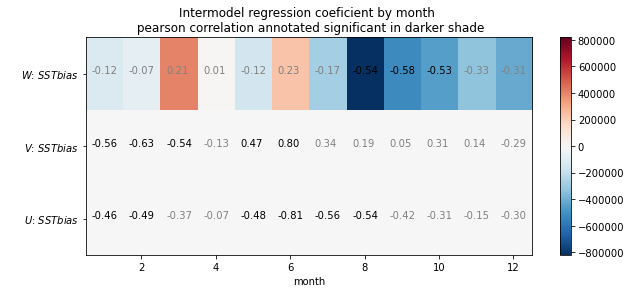

In [50]:
plot_regress_sst(c_WTIO)

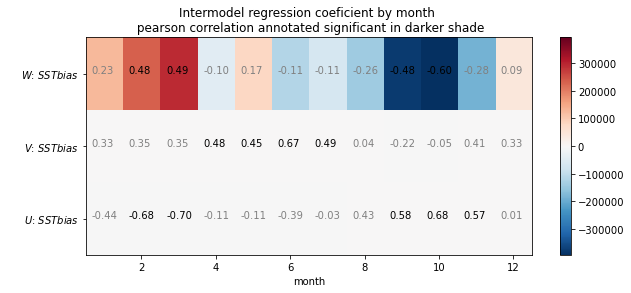

In [24]:
plot_regress_sst(c_SETIO)

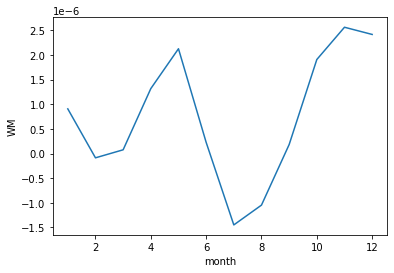

In [59]:
c_WTIO['WM'].median('model').plot()

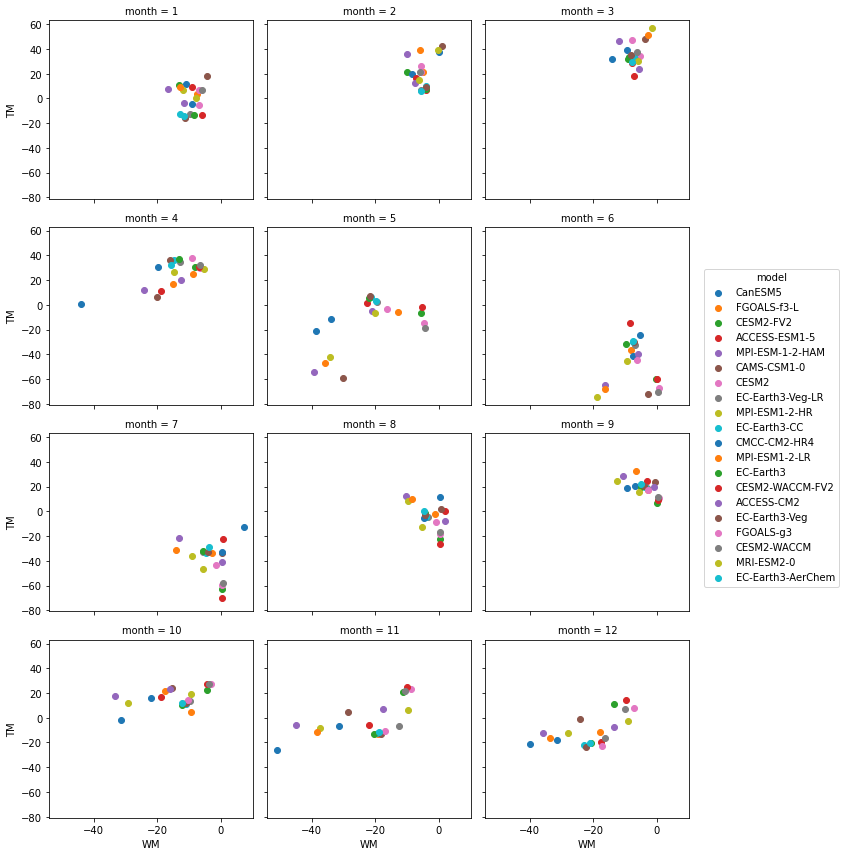

In [26]:
DS_WTIO.plot.scatter(x='WM', y='TM', col = 'month', col_wrap = 3, 
                hue =  'model', hue_style="discrete")

In [75]:
def scatter_corr_MM(MM_D, v1, v2, lat, lat_r, lon, lon_r):
    #r = xs.pearson_r(DS['T1'], DS['U1'], dim = 'model')
    #pv = xs.pearson_r_eff_p_value(DS['T1'], DS['U1'], dim = 'model')
    #now we can make a scatter plot of the strenght of the terms for each month
    #make size array for 20 models
    size = [1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,]
    #DS = DS.assign_coords({'sz':size})
    p = DS.plot.scatter(x='TM', y='UM', col = 'month', col_wrap = 3, 
                hue =  'model', hue_style="discrete")
    #calculate correlation coefficient
    
    for i, ax in enumerate(p.axes.flat):
        if i in [0,3,6,9]:
            ax.set_ylabel(v2)
        if i in [9,10,11]:
            ax.set_xlabel(v1)
        #ax.set_title((str('r = '), r.values[i]))
    return p

<xarray.DataArray 'SSTM' (model: 20, month: 12)>
array([[-1.76544189e-02, -3.97586823e-02, -8.68186951e-02,
        -2.11063385e-01, -1.64880753e-01,  2.09358215e-01,
         2.54388809e-01,  2.28713989e-01,  3.74965668e-01,
         4.83739853e-01,  2.68487930e-01,  5.94024658e-02],
       [-3.63992691e-01, -5.21444321e-01, -9.03266907e-01,
        -1.20018768e+00, -7.57932663e-01,  5.60932159e-02,
         1.80057526e-01,  4.04739380e-02, -4.47502136e-02,
        -2.40364075e-01, -5.69688797e-01, -5.40891647e-01],
       [ 5.12449265e-01,  4.50166702e-01,  1.51004791e-02,
        -3.09768677e-01,  1.52744293e-01,  8.16793442e-01,
         5.20048141e-01,  1.29379272e-01, -2.18902588e-01,
        -4.17661667e-01, -2.77830124e-01,  1.12964630e-01],
       [ 2.84608841e-01, -4.65793610e-02, -5.46072006e-01,
        -1.06365013e+00, -7.41516113e-01,  4.12073135e-01,
         8.27041626e-01,  7.18996048e-01,  7.31676102e-01,
         6.59816742e-01,  4.16009903e-01,  3.36664200e-01],
       [-1.32451057e+00, -1.39438248e+00, -1.34261131e+00,
        -1.28165054e+00, -1.50503159e+00, -2.05375099e+00,
        -1.96010780e+00, -1.84424400e+00, -1.67007637e+00,
        -1.36157036e+00, -1.16330528e+00, -1.22780800e+00],
...
       [ 1.21322632e-01, -3.34150314e-01, -6.85684204e-01,
        -5.59442520e-01,  2.26600647e-01,  8.66865158e-01,
         7.46362686e-01,  5.94020844e-01,  5.26956558e-01,
         5.89351654e-01,  2.77000427e-01,  2.01757431e-01],
       [ 1.95678711e-01,  3.70635986e-02, -1.43331528e-01,
        -1.87343597e-01,  3.84006500e-01,  1.12479401e+00,
         1.03347015e+00,  8.29214096e-01,  6.65599823e-01,
         5.71557999e-01,  3.95278931e-01,  2.39700317e-01],
       [ 1.00255585e+00,  8.92860413e-01,  5.46401978e-01,
         3.53662491e-01,  7.78745651e-01,  1.15903091e+00,
         8.89764786e-01,  6.25198364e-01,  3.18475723e-01,
         2.09104538e-01,  3.94166946e-01,  7.19989777e-01],
       [ 2.58987427e-01,  9.02576447e-02, -3.23575974e-01,
        -5.08729935e-01, -1.28879547e-02,  6.32127762e-01,
         5.42112350e-01,  2.70481110e-01,  7.68032074e-02,
         1.00708008e-02, -1.12356186e-01,  3.86600494e-02],
       [-8.46424103e-02, -5.18884659e-01, -9.65084076e-01,
        -9.12569046e-01, -1.93218231e-01,  4.14529800e-01,
         3.98519516e-01,  2.96829224e-01,  2.98692703e-01,
         3.75957489e-01,  6.55651093e-02,  2.63595581e-03]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * model    (model) <U17 'CanESM5' 'FGOALS-f3-L' ... 'EC-Earth3-AerChem'

In [60]:
import scipy
scipy.stats.binom_test(15,20,0.5)

0.04138946533203125